In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x44_D.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,1.511139,-0.223515,0.946930,-0.175524,-0.175524,1.241699,2.175892,-0.088824,0.195374,0.650273,0.162822,-0.392640,-0.060009,-0.142227,-0.013729,0.182902,-0.405876,0.390609,-0.848851,0.698931,0.0,0.655895,1.151668,-0.019956,-0.873672,2.604210,-0.883202,-0.104626,-0.392277,0.812980,-0.245324,-0.105786,-0.161171,-0.131657,-0.115377,-0.338908,-0.033405,-0.126882,-0.093131,-0.042832,-0.520822,-0.774070,1.194790,1.0
1,0.564527,0.110293,-0.431794,-0.847996,-0.847996,-0.799780,0.213470,0.612170,0.277261,-0.042050,-0.815670,0.687894,-0.060009,-0.142227,-0.013729,-0.011647,-0.405876,-0.805105,1.178063,0.698931,0.0,-1.524634,1.151668,-0.019956,-0.873672,2.604210,-0.883202,-0.104626,-0.392277,-1.230043,-0.245324,9.453027,-0.161171,-0.131657,-0.115377,-0.338908,-0.033405,-0.126882,-0.093131,-0.042832,-0.520822,1.291872,-0.836967,1.0
2,-0.129656,-0.159138,1.715609,0.945262,0.945262,-0.799780,0.136280,-0.439322,-0.623493,0.354388,-0.815670,-0.392640,-0.060009,-0.142227,-0.013729,-0.534775,-0.405876,-0.549710,-0.848851,0.698931,0.0,-1.524634,-0.361745,-0.019956,-0.873672,-0.383994,1.132244,9.557873,-0.392277,-1.230043,-0.245324,-0.105786,-0.161171,-0.131657,-0.115377,-0.338908,-0.033405,-0.126882,-0.093131,-0.042832,-0.520822,-0.774070,1.194790,0.0
3,-0.066548,0.044724,-0.397967,-0.175524,-0.175524,-0.799780,-0.326487,0.436922,1.096127,-0.415254,-0.815670,1.768427,-0.060009,-0.142227,-0.013729,1.500886,-0.405876,0.297738,1.178063,0.698931,0.0,-1.524634,1.151668,-0.019956,1.144595,-0.383994,-0.883202,-0.104626,-0.392277,0.812980,-0.245324,-0.105786,-0.161171,-0.131657,-0.115377,-0.338908,-0.033405,-0.126882,-0.093131,-0.042832,-0.520822,1.291872,-0.836967,0.0
4,1.511139,-0.151985,0.534013,0.496947,0.496947,1.241699,2.175892,0.787419,1.423674,1.199929,2.119807,0.687894,-0.060009,-0.142227,-0.013729,-0.541927,-0.405876,0.100387,-0.848851,0.698931,0.0,0.655895,1.151668,-0.019956,1.144595,-0.383994,-0.883202,-0.104626,-0.392277,-1.230043,-0.245324,-0.105786,-0.161171,-0.131657,-0.115377,2.950650,-0.033405,-0.126882,-0.093131,-0.042832,-0.520822,1.291872,-0.836967,0.0


In [4]:
data.shape

(12560, 44)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    8447
0.0    4113
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(12560, 43)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.67197452 0.67396497 0.67834395 0.67157643 0.66998408]
0.6731687898089171


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[ 258, 3855],
       [ 250, 8197]])

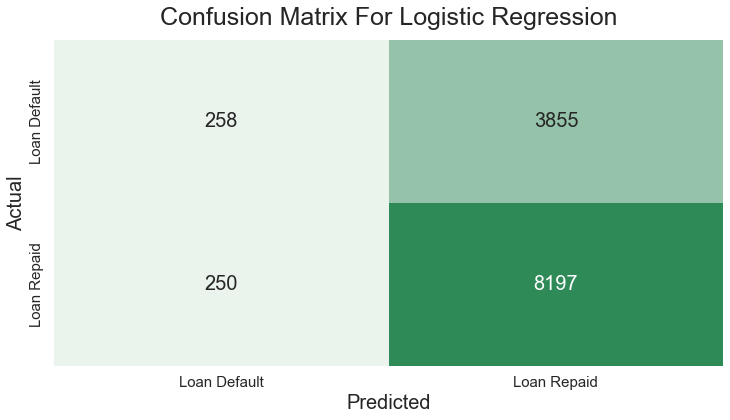

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.6731687898089171

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

8197
3855
250
258
0.6731687898089171


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    8447
0.0    4113
Name: loan_status_bin, dtype: int64

0.6725318471337579


In [17]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.6801360769996682

In [18]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [19]:
y_pred_prob

array([[0.49695751, 0.50304249],
       [0.33908825, 0.66091175],
       [0.46565151, 0.53434849],
       ...,
       [0.29630201, 0.70369799],
       [0.32798561, 0.67201439],
       [0.18728423, 0.81271577]])

In [20]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.8).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 1.])

In [21]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[3939,  174],
       [7598,  849]])

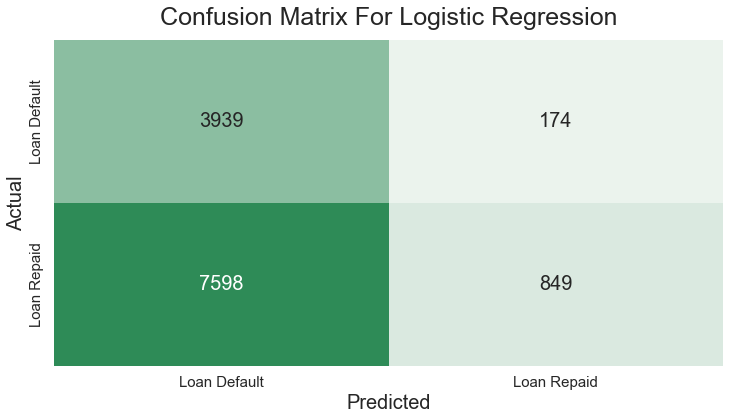

In [22]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [23]:
accuracy_score(y, y_pred_success)

0.3812101910828026

In [24]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

849
174
7598
3939
0.3812101910828026


In [25]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8299120234604106

In [ ]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [ ]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 